The goal of this notebook is to investigate our 2nd current working hypothesis, which states that peak I(EEG;TIA) optimal lag converges at 500 ms or later. I will try to get this to work with subject 2 for now; if it works I will expand it to other subjects. 

In [9]:
import mne
from pathlib import Path
import numpy as np
import neural_mi as nmi
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
import random
import seaborn as sns

In [2]:
# Prepare the data for subject 2
data_path = Path("../data/raw/P1-20251027T182958Z-1-001/P1/")
file_path = data_path / "binepochs filtered ICArej P1AvgBOS2.set"
epochs = mne.io.read_epochs_eeglab(file_path)

auditory_epochs = epochs[::2]
tactile_epochs = epochs[1::2]

auditory_epochs.filter(l_freq = 1., h_freq = 30., picks="eeg")
tactile_epochs.filter(l_freq = 1., h_freq = 30., picks="eeg")

X = epochs.get_data()  # shape (n_epochs, n_channels, n_times)
sfreq = auditory_epochs.info['sfreq']  # Sampling frequency

chan_a = 'T7'
chan_b = 'C3'

idx_a = auditory_epochs.ch_names.index(chan_a)
idx_b = auditory_epochs.ch_names.index(chan_b)

x_raw = X[:, idx_a, :]  # shape (n_epochs, n_times)
y_raw = X[:, idx_b, :]  # shape (n_epochs, n_times)
print(x_raw.shape, y_raw.shape)

x_concat = x_raw.reshape(-1)  # shape (n_epochs * n_times,)
y_concat = y_raw.reshape(-1)  # shape (n_epochs * n_times,

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_concat.reshape(-1, 1)).reshape(1,-1)
y_scaled = scaler.fit_transform(y_concat.reshape(-1, 1)).reshape(1,-1)

print(x_scaled.shape, y_scaled.shape)

x_scaled = x_scaled.reshape(120, 1792)
y_scaled = y_scaled.reshape(120, 1792)

print(x_scaled.shape, y_scaled.shape)


Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS2.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.


C:\Users\Rinta\AppData\Local\Temp\ipykernel_25556\240973482.py:4: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)


Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 s)

Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fil

In [3]:
# Base parameters for our MI estimator. We'll use a simple MLP.
BASE_PARAMS = {
    'embedding_dim': 16,
    'hidden_dim': 32,
    'n_layers': 2,
    'learning_rate': 1e-3,
    'batch_size': 128,
    'n_epochs': 30,
    'patience': 15,
}

# Plotting function for X and Y
def plot_data(x, y, title=None, xlim=100):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(x.T, label=r'$x(t)$')
    ax.plot(y.T, label=r'$y(t)$')
    ax.set_xlabel('Timepoints')
    ax.set_ylabel('Value')
    if title:
        ax.set_title(title)
    ax.set_xlim(0, xlim)
    ax.legend()
    plt.show()

In [ ]:
# Snippet for benchmarking PyTorch with CUDA
import torch, time
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Warm-up
for _ in range(3):
    torch.matmul(torch.randn(2048, 2048, device=device),
                 torch.randn(2048, 2048, device=device))

torch.cuda.synchronize()

# GPU benchmark (takes ~0.5 seconds normally)
start = time.time()
for _ in range(100):
    a = torch.randn(2048, 2048, device=device)
    b = torch.randn(2048, 2048, device=device)
    c = torch.matmul(a, b)
torch.cuda.synchronize()
print(f"GPU batch run: {time.time() - start:.4f} seconds")

# CPU benchmark (takes ~10 seconds normally)
# start = time.time()
# for _ in range(100):
#     a_cpu = torch.randn(2048, 2048)
#     b_cpu = torch.randn(2048, 2048)
#     c_cpu = torch.matmul(a_cpu, b_cpu)
# print(f"CPU batch run: {time.time() - start:.4f} seconds")

print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
print(torch.backends.cudnn.is_available())
print(torch.version.cuda)

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU name: NVIDIA GeForce RTX 3060 Laptop GPU
Using device: cuda
GPU batch run: 0.3174 seconds
CPU batch run: 10.2662 seconds
NVIDIA GeForce RTX 3060 Laptop GPU
True
True
12.4


In [23]:
raw_results = nmi.run(
    x_data=x_scaled,
    y_data=y_scaled,
    mode='lag',
    processor_type_x='continuous',
    processor_params_x={'window_size': 95},
    processor_type_y='continuous',
    processor_params_y={'window_size': 95},
    lag_range=range(450, 1000, 12),
    base_params=BASE_PARAMS,
    n_workers=4, # 30 sec w/ 4 & 8 workers, 43 sec w/ 12, OOM w/ 16
    random_seed=42
)

2025-10-28 22:28:08 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-28 22:28:08 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:28:08 - neural_mi - INFO - Preparing 46 tasks for lag analysis.
2025-10-28 22:28:08 - neural_mi - INFO - Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/46 [00:00<?, ?task/s]

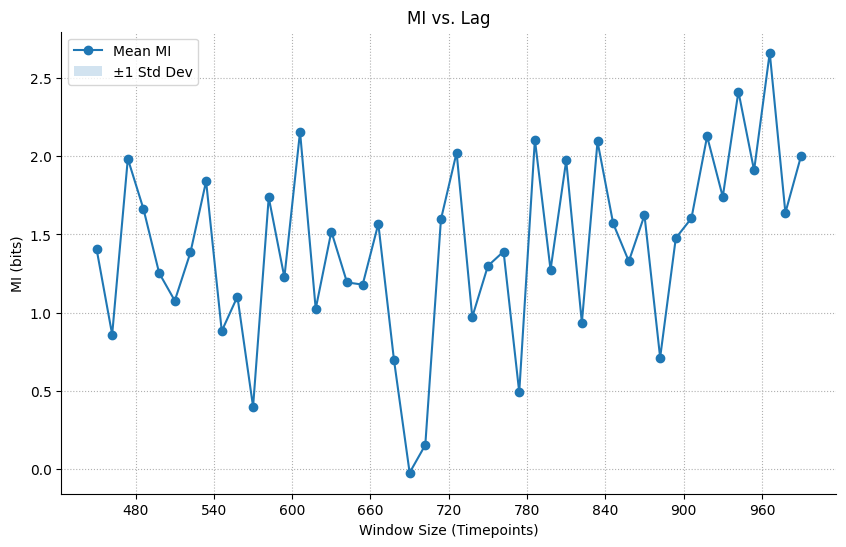

In [24]:
ax = raw_results.plot(show=False)
ax.set_xlabel('Window Size (Timepoints)')
ax.legend()
plt.show()

Doesn't make much sense, but that was expected. There are many directions for improvement (low-pass filter, loop over subjects and channels)

In [7]:
lag_range = range(450, 750, 12)
window_range = list(range(5, 101, 5))
mi_results_2d = []

print("Starting 2D sweep...")
for lag in tqdm(lag_range, desc="Lag Sweep Progress"):
    results = nmi.run(
        x_data=x_scaled,
        y_data=y_scaled,
        mode='sweep',
        processor_type_x='continuous',
        processor_type_y='continuous',
        processor_params_x={},
        processor_params_y={},
        base_params=BASE_PARAMS,
        sweep_grid={'window_size': window_range},
        n_workers=8,
        verbose=False
    )

    for _, row in results.dataframe.iterrows():
        mi_results_2d.append({
            'lag': lag, 
            'window_size': row['window_size'],
            'mi': row['mi_mean']
        })

print("2D sweep complete!")
results_df_2d = pd.DataFrame(mi_results_2d)

Starting 2D sweep...


Lag Sweep Progress:   0%|          | 0/25 [00:00<?, ?it/s]

2025-10-28 22:06:55 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:06:55 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:07:15 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:07:15 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:07:15 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:07:39 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:07:39 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:07:39 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:08:01 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:08:01 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:08:01 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:08:23 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:08:23 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:08:23 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:08:46 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:08:46 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:08:46 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:09:06 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:09:06 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:09:06 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:09:27 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:09:27 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:09:27 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:09:51 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:09:51 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:09:51 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:10:16 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:10:16 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:10:16 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:10:42 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:10:42 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:10:42 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:11:07 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:11:07 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:11:07 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:11:31 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:11:31 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:11:31 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:11:52 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:11:52 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:11:52 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:12:15 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:12:15 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:12:15 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:12:38 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:12:38 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:12:38 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:13:01 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:13:01 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:13:01 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:13:26 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:13:26 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:13:26 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:13:49 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:13:49 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:13:49 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:14:14 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:14:14 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:14:14 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:14:38 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:14:38 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:14:38 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:15:02 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:15:02 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:15:02 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:15:26 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:15:26 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:15:26 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:15:51 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:15:51 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:15:51 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:16:17 - neural_mi - INFO - Parameter sweep finished.
2025-10-28 22:16:17 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:16:17 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/20 [00:00<?, ?task/s]

2025-10-28 22:16:42 - neural_mi - INFO - Parameter sweep finished.
2D sweep complete!


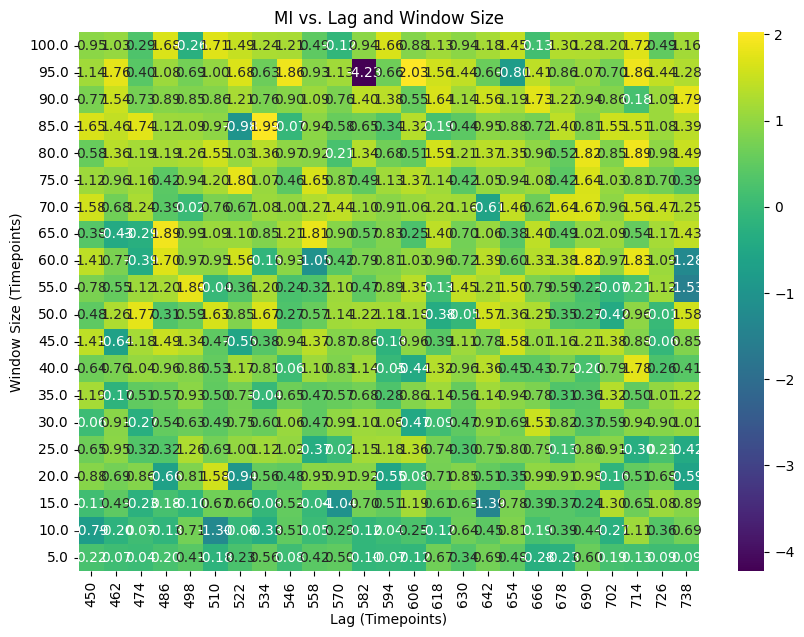

In [10]:
# Pivot the data for the heatmap
heatmap_data = results_df_2d.pivot(index='window_size', columns='lag', values='mi')

plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f")
plt.title('MI vs. Lag and Window Size')
plt.xlabel('Lag (Timepoints)')
plt.ylabel('Window Size (Timepoints)')
plt.gca().invert_yaxis()
plt.show()

What's going on at 582 ms of lag, 95 timepoint window? 

In [ ]:
# Snippet for testing random channel pairs
# ---------------- CONFIGURATION ---------------- #
DATA_PATH = Path("../data/raw/P1-20251027T182958Z-1-001/P1/")
FILE_NAME = "binepochs filtered ICArej P1AvgBOS2.set"
OUTPUT_DIR = Path("../results/mi_lag_analysis_P1/")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

N_PAIRS = 10  # number of random channel pairs to analyze
LAG_RANGE = range(400, 800, 10)  # in timepoints (depends on your sampling rate)

# NeuralMI base parameters
BASE_PARAMS = {
    'embedding_dim': 16,
    'hidden_dim': 32,
    'n_layers': 2,
    'learning_rate': 1e-3,
    'batch_size': 128,
    'n_epochs': 30,
    'patience': 15,
}

# ------------------------------------------------ #

# === 1. Load and preprocess data ===
file_path = DATA_PATH / FILE_NAME
epochs = mne.io.read_epochs_eeglab(file_path)

# Split auditory/tactile conditions (optional)
auditory_epochs = epochs[::2]
tactile_epochs = epochs[1::2]
sfreq = auditory_epochs.info['sfreq']

# Apply band-pass filter (in-place)
auditory_epochs.filter(*BANDPASS_RANGE, fir_design='firwin', verbose=False)

# Extract data array
X = auditory_epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
ch_names = auditory_epochs.ch_names

print(f"Data shape: {X.shape}, Sampling rate: {sfreq} Hz")

# === 2. Choose random pairs ===
pairs = [('T7', 'C3')]
# while len(pairs) < N_PAIRS:
#     a, b = random.sample(ch_names, 2)
#     if (a, b) not in pairs and (b, a) not in pairs:
#         pairs.append((a, b))

print("Channel pairs:", pairs)

Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS2.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.


C:\Users\Rinta\AppData\Local\Temp\ipykernel_11208\3378394966.py:26: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)


Data shape: (60, 32, 1792), Sampling rate: 512.0 Hz
Channel pairs: [('T7', 'C3')]


Analyzing random pairs:   0%|          | 0/10 [00:00<?, ?it/s]

2025-10-27 20:15:23 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-27 20:15:23 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-27 20:15:23 - neural_mi - INFO - Preparing 40 tasks for lag analysis.
2025-10-27 20:15:23 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/40 [00:00<?, ?task/s]

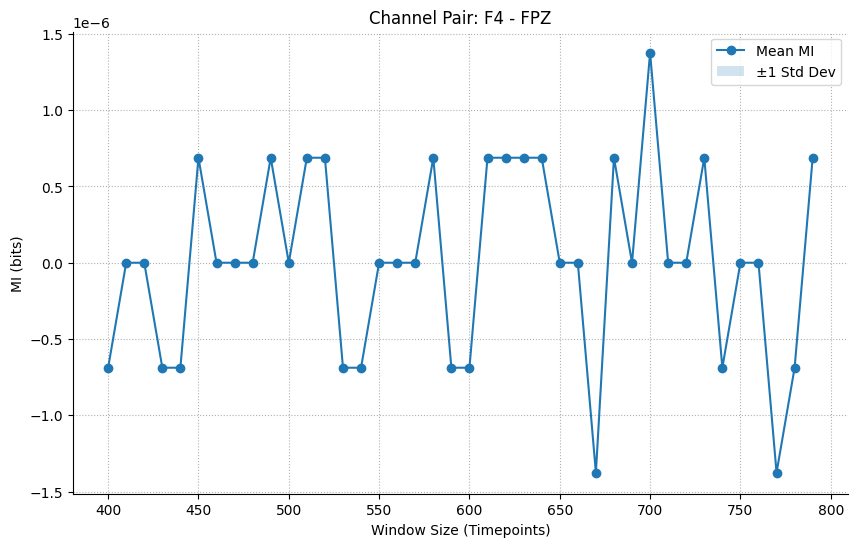

2025-10-27 20:16:02 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-27 20:16:02 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-27 20:16:02 - neural_mi - INFO - Preparing 40 tasks for lag analysis.
2025-10-27 20:16:02 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/40 [00:00<?, ?task/s]

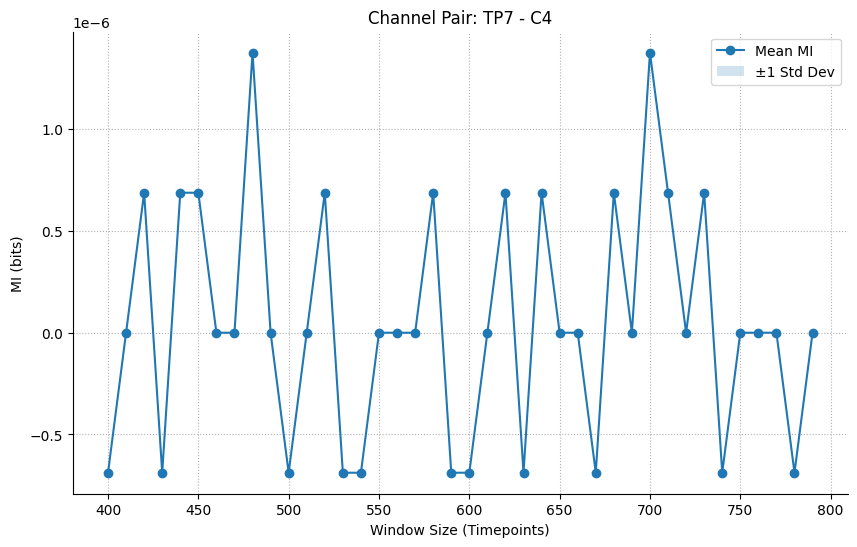

2025-10-27 20:16:46 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-27 20:16:47 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-27 20:16:47 - neural_mi - INFO - Preparing 40 tasks for lag analysis.
2025-10-27 20:16:47 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/40 [00:00<?, ?task/s]

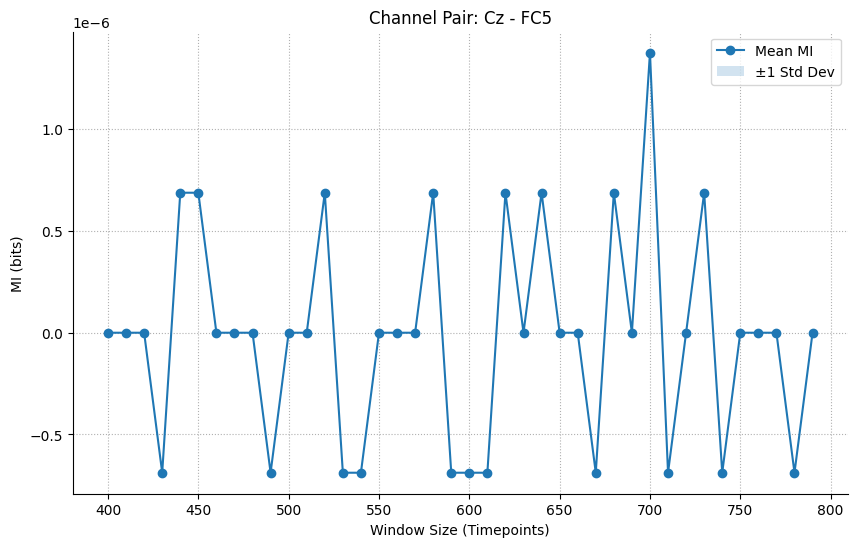

2025-10-27 20:17:24 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-27 20:17:24 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-27 20:17:24 - neural_mi - INFO - Preparing 40 tasks for lag analysis.
2025-10-27 20:17:24 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/40 [00:00<?, ?task/s]

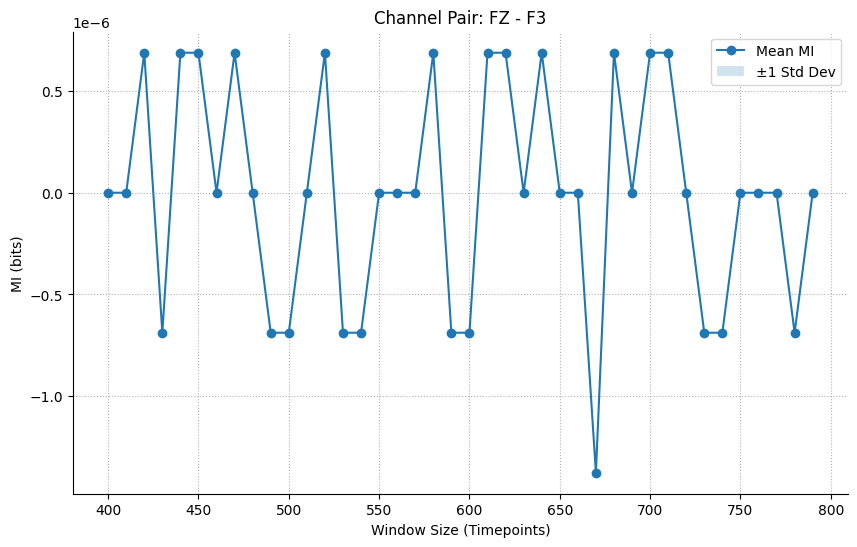

2025-10-27 20:18:02 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-27 20:18:02 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-27 20:18:02 - neural_mi - INFO - Preparing 40 tasks for lag analysis.
2025-10-27 20:18:02 - neural_mi - INFO - Starting parameter sweep with 8 workers...


Parameter Sweep Progress:   0%|          | 0/40 [00:00<?, ?task/s]

In [ ]:
for i, (chan_a, chan_b) in enumerate(tqdm(pairs, desc="Analyzing random pairs")):
    idx_a = ch_names.index(chan_a)
    idx_b = ch_names.index(chan_b)

    x_raw = X[:, idx_a, :]  # shape (n_epochs, n_times)
    y_raw = X[:, idx_b, :]  # shape (n_epochs, n_times

    rand_results = nmi.run(
        x_data=x_raw,
        y_data=y_raw,
        mode='lag',
        processor_type_x='continuous',
        processor_params_x={'window_size': 1},
        processor_type_y='continuous',
        processor_params_y={'window_size': 1},
        lag_range=LAG_RANGE,
        base_params=BASE_PARAMS,
        n_workers=4,
        random_seed=42
    )

    ax = rand_results.plot(show=False)
    ax.set_xlabel('Window Size (Timepoints)')
    ax.set_title(f'Channel Pair: {chan_a} - {chan_b}')
    ax.legend()
    plt.show()

Calculate channel averages over all subjects